In [87]:
from pymatgen.ext.matproj import MPRester
from pymatgen.io.cif import CifWriter
from IPython.display import FileLink
from pymatgen.phonon.plotter import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.integrate import quad

In [88]:
with MPRester("n58KMF7umZMAJXouXDJc0vORWlcEfEsD") as m :
    struc = m.get_structure_by_material_id("mp-23209")
    bs = m.get_phonon_bandstructure_by_material_id("mp-23209")
    dos = m.get_phonon_dos_by_material_id("mp-23209") 

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

In [89]:
t = np.array(np.arange(5, 1000, 5))
R = 8.314
h = 6.62607015e-34 
k_b = 1.38064852e-23
nat = len(struc)
ph_cv = np.array([dos.cv(t[i]) for i in range(len(t))]) / (3 * nat * R)

In [90]:
# Debye 

def integrand(x):
    return x**4 * np.exp(x) / (np.exp(x) - 1)**2

def Debye(T, theta_D):
    return 3 * ((T/theta_D)**3) * quad(integrand, 0, theta_D/T)[0] 

def error_Debye(theta_D):
    return np.sum([(Debye(t[i], theta_D) - ph_cv[i])**2 for i in range(len(t))])

theta_D_init = 250
theta_D_optimal = minimize(error_Debye, theta_D_init).x[0]
print("La température de Debye vaut   : ",theta_D_optimal," [K]")

# Einstein 

def Einstein(T, theta_E):
    exp = np.exp(theta_E/T)
    return (theta_E/T)**2 * (exp/(exp-1)**2)

def error_Einstein(theta_E):
    Cv_E = Einstein(t, theta_E)  
    return np.sum((ph_cv - Cv_E)**2)

theta_E_init = 250
theta_E_optimal = minimize(error_Einstein, theta_E_init).x[0]

print("La température d'Einstein vaut : ",theta_E_optimal,"[K]")

La température de Debye vaut   :  254.18882351882561  [K]
La température d'Einstein vaut :  188.0041525394988 [K]


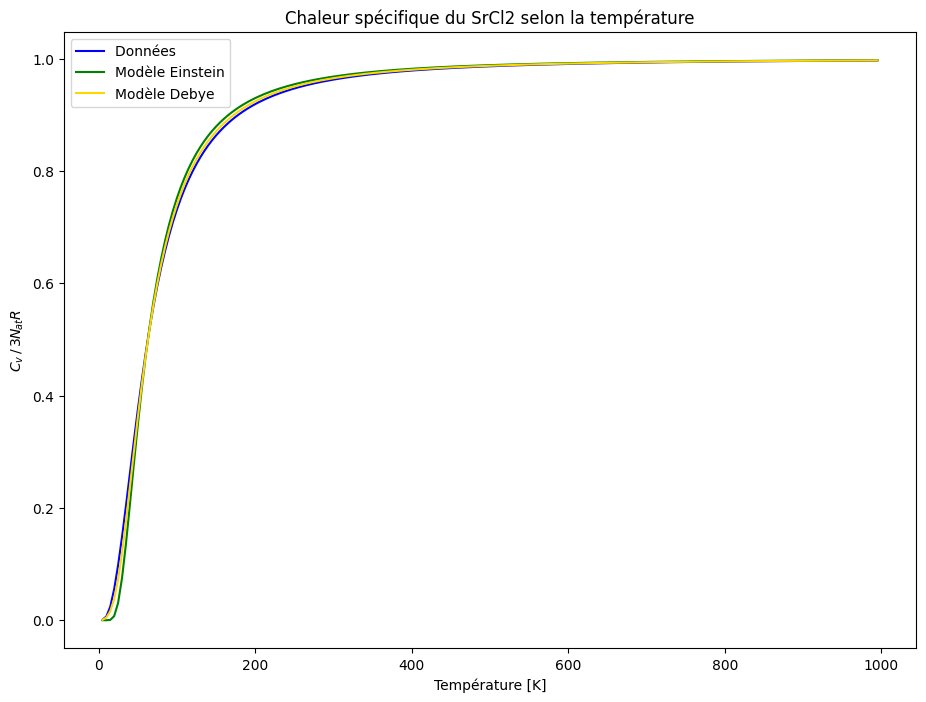

In [91]:
# Courbes de chaleur spécifique 

Cv_E = Einstein(t, theta_E_optimal)
Cv_D = np.array([Debye(T, theta_D_optimal) for T in t])

plt.figure(figsize=(11, 8))
plt.plot(t, ph_cv, label="Données ", color='blue')
plt.plot(t, Cv_E, label="Modèle Einstein", color='green')
plt.plot(t, Cv_D, label="Modèle Debye", color='gold')
plt.xlabel('Température [K]')
plt.ylabel("$C_v\,/\,3N_{\!at}R$")
plt.title("Chaleur spécifique du SrCl2 selon la température")
plt.legend()
plt.show()

fréquence de Debye = 254.18882351882561 THz
fréquence d'Einstein = 188.0041525394988 THz


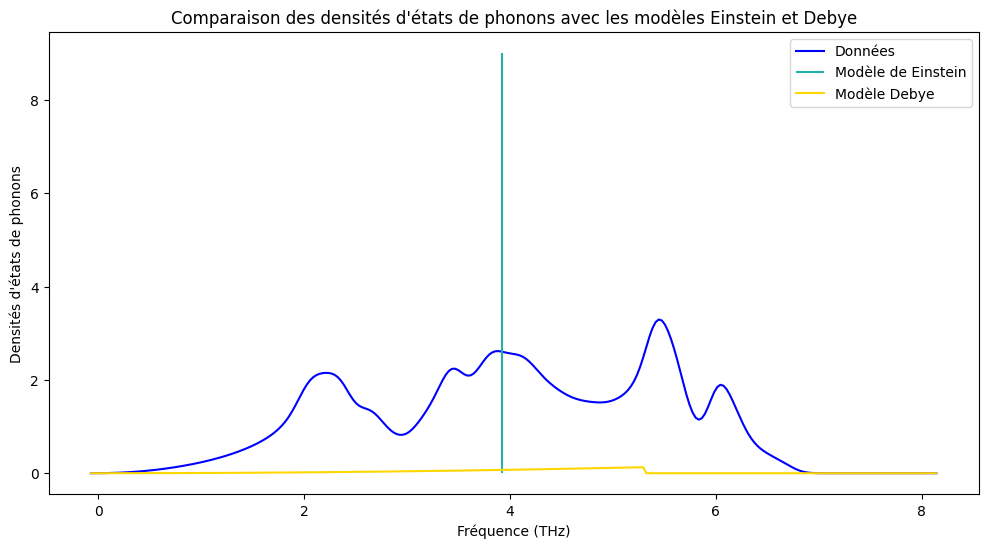

In [92]:
# Représentation les trois densités d'états de phonons correspondantes

#Calcule des fréquences 

k_B = 1.380649e-23
hbar = 1.054e-34  
toTHz = 1e-12     
freq = dos.frequencies 
dens = dos.densities
o_E = toTHz * (theta_E_optimal * k_B)/hbar
o_D = toTHz * (theta_D_optimal * k_B)/hbar

print("fréquence de Debye =",theta_D_optimal,"THz")
print("fréquence d'Einstein =",theta_E_optimal,"THz")

# Visualisation 

dens_D = np.zeros(len(freq))
for i,f in enumerate(freq):
    o = 2*np.pi*f
    if o < o_D:
        dens_D[i] = (9*nat*(o)**2/(o_D**3))

plt.figure(figsize=(12, 6))
plt.plot(freq, dens, color='blue', label="Données") 
plt.vlines(o_E/(2*np.pi), 0, 3*nat, colors="lightseagreen", label="Modèle de Einstein")
plt.plot(freq, dens_D/(2*np.pi), color='gold', label="Modèle Debye")
plt.ylabel("Densités d'états de phonons")
plt.xlabel("Fréquence (THz)")
plt.title("Comparaison des densités d'états de phonons avec les modèles Einstein et Debye")
plt.legend()
plt.show()